## Imports

In [1]:
# Making imports convenient
import sys
import os
PATH=os.getcwd().split('/notebooks')[0]
sys.path.insert(1, PATH)

In [28]:
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from datasets import load_dataset, Dataset, concatenate_datasets
import transformers
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix


from transformers import AutoTokenizer, DataCollatorWithPadding,BertForSequenceClassification,TrainingArguments,Trainer

from src.utils.myutils import *
import yaml
from tqdm import tqdm
import logging
import json
import warnings
import random
import pandas as pd
from newspaper import Article
from nltk import sent_tokenize
import seaborn as sns

logging.disable(logging.ERROR)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning) 

CS_DATA_PATH = PATH + '/data/CS/processed/'
CONFIG_PATH = PATH + '/src/utils/config.yaml'
FINAL_PATH = '/home/horyctom/bias-detection-thesis/src/models/trained/final_classifier.pth'


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model_name = 'fav-kky/FERNET-C5'
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False,padding=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained("horychtom/czech_media_bias_classifier")

BATCH_SIZE = 32

## Function definitions

In [23]:
def classify_sentence(sent:str):
    toksentence = tokenizer(sent,truncation=True,return_tensors="pt",max_length=128)
    model.eval()
    model.to(device)
    with torch.no_grad():
        toksentence.to(device)
        output = model(**toksentence)
    
    classification = F.softmax(output.logits,dim=1).argmax(dim=1)
    
    return classification[0].item()

In [24]:
def classify_sentence_bias_prob(sent:str):
    toksentence = tokenizer(sent,truncation=True,return_tensors="pt",max_length=128)
    model.eval()
    model.to(device)
    with torch.no_grad():
        toksentence.to(device)
        output = model(**toksentence)
    
    classification = F.softmax(output.logits,dim=1).squeeze(dim=0)
    
    return classification[1]

In [25]:
def classify_article(url:str):
    article = Article(url)
    article.download()
    article.parse()
    sentences = sent_tokenize(article.text)
    annotations = np.array(list(zip(sentences,list(map(classify_sentence,sentences)))))
    probabilities = np.array(list(zip(sentences,list(map(classify_sentence_certainty,sentences)))))
    return annotations,probabilities

In [26]:
def strip_domains(data):
    get_domain = lambda x : '.'.join(x.split('.')[-2:])
    get_section = lambda x : x.split('.')[0] if '.' in x else x
    data['subdomain'] = data['subdomain'].apply(get_domain)
    data['section'] = data['section'].apply(get_section)
    
    return data

In [27]:
def date_format(data):
    data['published'] = data['published'].apply(lambda x: x[:7])
    data = data.assign(Year = data['published'].apply(lambda x: int(x[:4])))
    
    return data

In [77]:
def assign_bias_ratio(data,split:str):
    size = len(data)
    values = np.zeros(size)
    
    for i in tqdm(range(size)):
        text = data.iloc[i][split]
        sentences = sent_tokenize(text)
        labels = np.array(list(map(classify_sentence,sentences)))
        values[i] = 100*np.sum(labels)/len(labels)
    
    data.insert(0,split+'_bias',values)
    
    return data

In [78]:
def assign_bias_headline(data):
    size = len(data)
    values = np.zeros(size)
    
    for i in tqdm(range(size)):
        text = data.iloc[i]['headline']
        values[i] = classify_sentence_bias_prob(text)
        
    data.insert(0,'headline_bias',values)
    
    return data

## Load and clean data

In [184]:
test = pd.read_json('/mnt/data/factcheck/summarization/sumeczech/sumeczech-1.0-test.jsonl',lines=True)
dev = pd.read_json('/mnt/data/factcheck/summarization/sumeczech/sumeczech-1.0-dev.jsonl',lines=True)
data = pd.concat([test,dev])

#throaway blogs
data = data[~data['subdomain'].str.contains('blog')]

In [187]:
data.drop(['filename', 'dataset','md5','offset'], axis=1, inplace=True)

In [ ]:
data = data[data['published']!='']
data = date_format(data)
data = strip_domains(data)

In [192]:
denik = data[data.subdomain == 'denik.cz']
ctk = data[data.subdomain == 'ceskenoviny.cz']
idnes = data[data.subdomain == 'idnes.cz']
lidovky = data[data.subdomain == 'lidovky.cz']
novinky = data[data.subdomain == 'novinky.cz']

## Idnes.cz experiments

In [210]:
idnes = assign_bias_ratio(idnes,'abstract')
idnes = assign_bias_headline(idnes)

100%|██████████| 39081/39081 [08:46<00:00, 74.19it/s]


In [211]:
idnes.to_csv('./indes_data.csv',index=False)

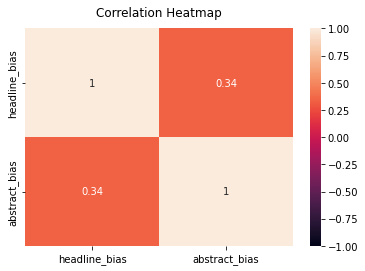

In [212]:
df = idnes[['headline_bias','abstract_bias']]
plt.figure(figsize=(6, 4))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

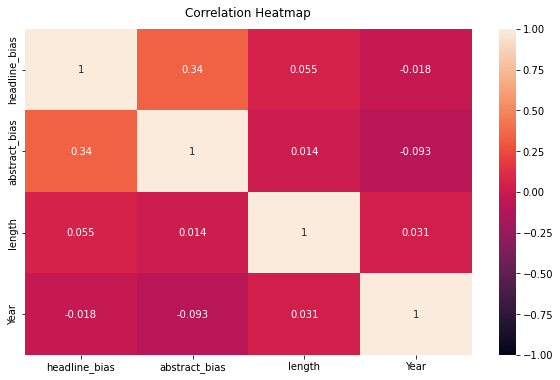

In [213]:
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(idnes.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [217]:
df = idnes.groupby('published',as_index=False).agg({'headline_bias':'mean'})
df.corr()

,headline_bias
headline_bias,1.0


In [225]:
df = idnes.groupby('section',as_index=False).agg({'headline_bias':'mean'})

In [226]:
df.sort_values(by='headline_bias')

,section,headline_bias
37,z-radnic-a-obci,0.007430
19,oh,0.045119
14,kraje,0.050670
6,cestiny,0.088057
35,wiki,0.090523
25,plzen,0.100826
38,zlin,0.103501
33,vary,0.110620
20,olomouc,0.113115
4,budejovice,0.115013


## Denik.cz experiments

#### interesting properties 
    - length
    - bias of headline, abstract, text
    - section
    - subdomain
    - time

In [193]:
denik = assign_bias_ratio(denik,'abstract')
denik = assign_bias_headline(denik)

100%|██████████| 14413/14413 [03:17<00:00, 72.87it/s]


In [228]:
denik = assign_bias_ratio(denik,'text')

100%|██████████| 14413/14413 [1:25:23<00:00,  2.81it/s]  


In [ ]:
denik['published'] = pd.to_datetime(denik['published'], format = '%Y-%m')

In [231]:
denik.to_csv('./denik_data.csv',index=False)

In [345]:
denik = denik[denik['section'] != 'komentare']

In [346]:
denik = denik[denik['section'] != 'fejeton']

### Correlation between different granularities

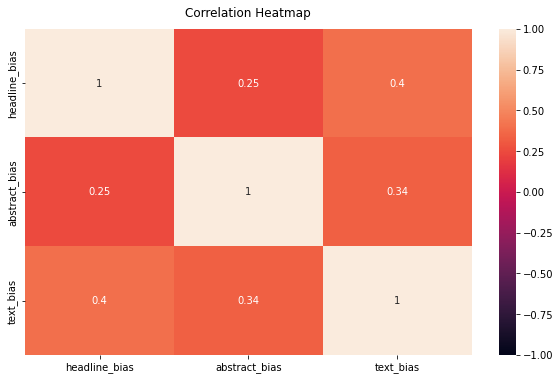

In [367]:
df = denik[['headline_bias','abstract_bias','text_bias']]
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

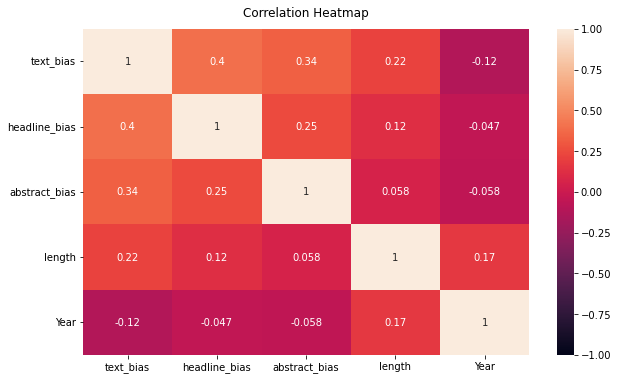

In [368]:
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(denik.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [391]:
df_years = denik.groupby('Year',as_index=False).agg({'text_bias':'mean'})
df_months = denik.groupby('published',as_index=False).agg({'text_bias':'mean'})

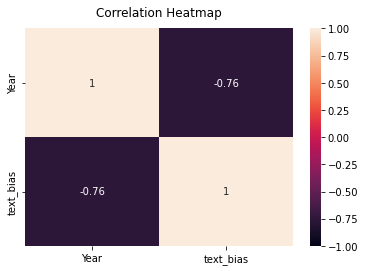

In [371]:
plt.figure(figsize=(6, 4))
heatmap = sns.heatmap(df_years.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [372]:
df_years

,Year,text_bias
0,2007,0.108502
1,2008,0.119969
2,2009,0.120925
3,2010,0.085044
4,2011,0.070475
5,2012,0.076541
6,2013,0.076334
7,2014,0.071083
8,2015,0.071454
9,2016,0.071549


Text(0.5, 1.0, 'Medi Bias development over years')

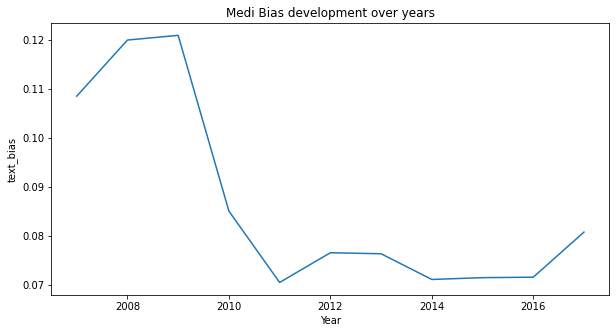

In [373]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(ax = ax, x='Year', y='text_bias', data=df_years).set_title('Medi Bias development over years')

Text(0.5, 1.0, 'Media Bias development over months')

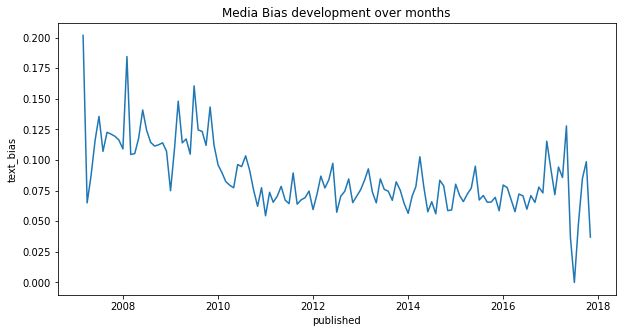

In [394]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(ax = ax, x='published', y='text_bias', data=df_months).set_title('Media Bias development over months')

## Bias across different topics/sections

In [375]:
df_sections = denik.groupby('section',as_index=False).agg({'text_bias':'mean'})

In [377]:
df_sections.sort_values(by='text_bias')

,section,text_bias
20,radar,0.000000
8,ekonomika,0.028877
24,reklama,0.031250
35,vzdelavani,0.040000
28,special,0.041667
2,bydleni,0.047952
17,krimi,0.048424
36,zdravi,0.049762
1,auto,0.053181
15,klasa,0.062500
